<a href="https://colab.research.google.com/github/Bappy60/ML_Assignment/blob/main/Final%20Lab%20Problem%201/X_ray_image_classification_with_CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author Name : Kawsar Ahemmed Bappy*

*Registration Number : 2018831060*

#Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
import albumentations as A
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.layers import Conv2D,SeparableConv2D,Input, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
!pip install google-colab
import google.colab.drive as drive

#Loading the Dataset



In [ ]:
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Archive.zip"

## Cheking the dataset

In [ ]:
!ls -l

In [ ]:
!ls -l train/NORMAL

##Loading data into variable


In [8]:
train_data = glob.glob('train/**/*.jpeg')
test_data = glob.glob('test/**/*.jpeg')
val_data = glob.glob('val/**/*.jpeg')
print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


#Data Exploration

In [ ]:
!ls -l /content

In [10]:
DIR = "/content"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [13]:
train_dir="train"
test_dir="test"
val_dir="val"


print("Train set:\n========================================")
num_pneumonia=len(os.listdir(os.path.join(train_dir,'PNEUMONIA')))
num_normal=len(os.listdir(os.path.join(train_dir,'NORMAL')))

print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


In [14]:
## Plotly chart for Class distribution
labels = ["Normal",'Pneumonia ']
values = [len(all_normal), len(all_pneumonia)]
colors = ['green', 'pink']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.5)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Image Category Distribution",
                  titlefont={'size': 30},
                  )
iplot(fig)

#Data Augmentation
Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation can be much more helpful where the dataset is imbalanced. one can generate different samples of undersampled class in order to try to balance the overall distribution.

The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [16]:
# Initialize the ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False # randomly flip images
)

For the data augmentation, i choosed to :

1.   Randomly rotate some training images by 30 degrees

2.  Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.

Once our model is ready, we fit the training dataset.

#Data Generator

In [17]:
# Load images from the train directory
train_generator = train_datagen.flow_from_directory(
    'train',
    shuffle=True,
    target_size=(224, 224),  # adjust to the input size of your model
    batch_size=32,  # adjust based on your requirements
    class_mode='binary'  # or 'categorical' for multi-class problems
)

Found 5216 images belonging to 2 classes.


In [18]:
# Initialize the ImageDataGenerator for validation and test data (without data augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the validation directory
val_generator = val_test_datagen.flow_from_directory(
    'val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load images from the test directory
test_generator = val_test_datagen.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Data Visualization


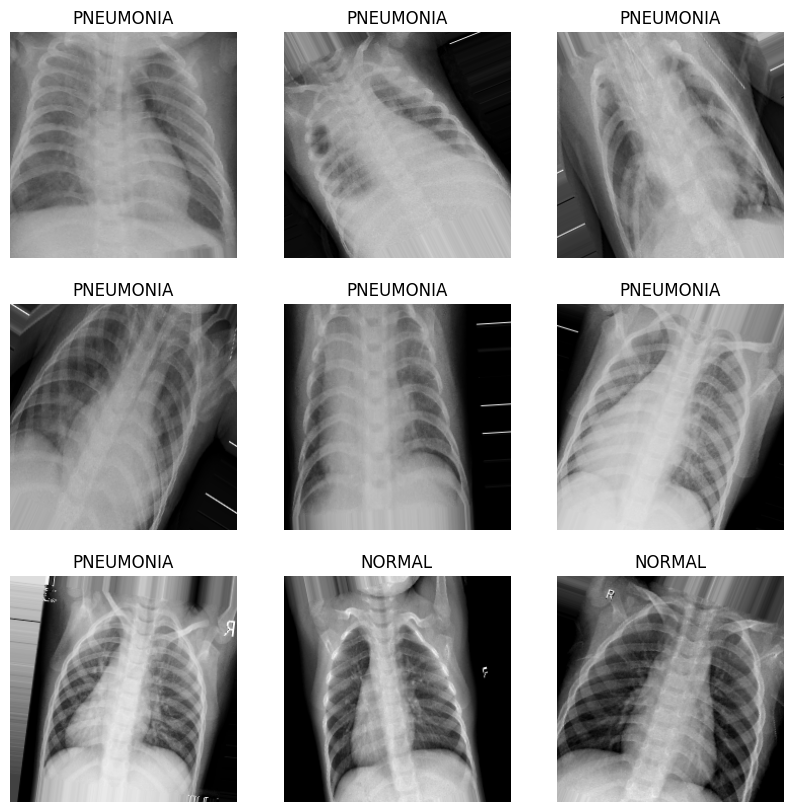

In [19]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Plot the images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[int(labels[i])])  # map numeric labels to class names
    plt.axis('off')
plt.show()

#Build CNN Model

In [28]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [29]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [30]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [20]:
# def build_model():
#     input_img = Input(shape=(224,224,3), name='ImageInput')
#     x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
#     x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
#     x = MaxPooling2D((2,2), name='pool1')(x)

#     x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
#     x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
#     x = MaxPooling2D((2,2), name='pool2')(x)

#     x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
#     x = BatchNormalization(name='bn1')(x)
#     x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
#     x = BatchNormalization(name='bn2')(x)
#     x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
#     x = MaxPooling2D((2,2), name='pool3')(x)

#     x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
#     x = BatchNormalization(name='bn3')(x)
#     x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
#     x = BatchNormalization(name='bn4')(x)
#     x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
#     x = MaxPooling2D((2,2), name='pool4')(x)

#     x = Flatten(name='flatten')(x)
#     x = Dense(1024, activation='relu', name='fc1')(x)
#     x = Dropout(0.7, name='dropout1')(x)
#     x = Dense(512, activation='relu', name='fc2')(x)
#     x = Dropout(0.5, name='dropout2')(x)
#     x = Dense(1, activation='sigmoid', name='fc3')(x)

#     model = Model(inputs=input_img, outputs=x)
#     return model

In [31]:
model =  build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 56, 56, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 128)       27072     
                                                      

In [32]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

opt = Adam(learning_rate=0.001)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy',
              metrics=METRICS,
              optimizer=opt,
              run_eagerly=True)


In [33]:
batch_size = 32
nb_epochs = 20

#Correcting Data imbalance using Class weight
Due a imbalanced class we shoud compensate defining the class_weight.

In [34]:
class_weight ={0:1.95, 1:0.67}

#Train the Model

In [35]:
%%time
# Fit the model
history = model.fit(train_generator,
                    epochs=nb_epochs,
                    steps_per_epoch=len(train_data)/ batch_size,
                    validation_data=val_generator,
                    callbacks=[es, chkpt],
                    class_weight=class_weight)

Epoch 1/20
163/163 [==============================] - 126s 707ms/step - loss: 0.2624 - accuracy: 0.7824 - precision: 0.9338 - recall: 0.7610 - val_loss: 0.9649 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/20
163/163 [==============================] - 123s 754ms/step - loss: 0.1688 - accuracy: 0.8763 - precision: 0.9609 - recall: 0.8689 - val_loss: 2.1065 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/20
163/163 [==============================] - 117s 716ms/step - loss: 0.1595 - accuracy: 0.8898 - precision: 0.9583 - recall: 0.8903 - val_loss: 3.1121 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/20
163/163 [==============================] - 118s 723ms/step - loss: 0.1458 - accuracy: 0.8980 - precision: 0.9650 - recall: 0.8952 - val_loss: 3.4380 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/20
163/163 [==============================] - 118s 720ms/step - loss: 0.1328 - a

# Visualizing model performance
Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the training.



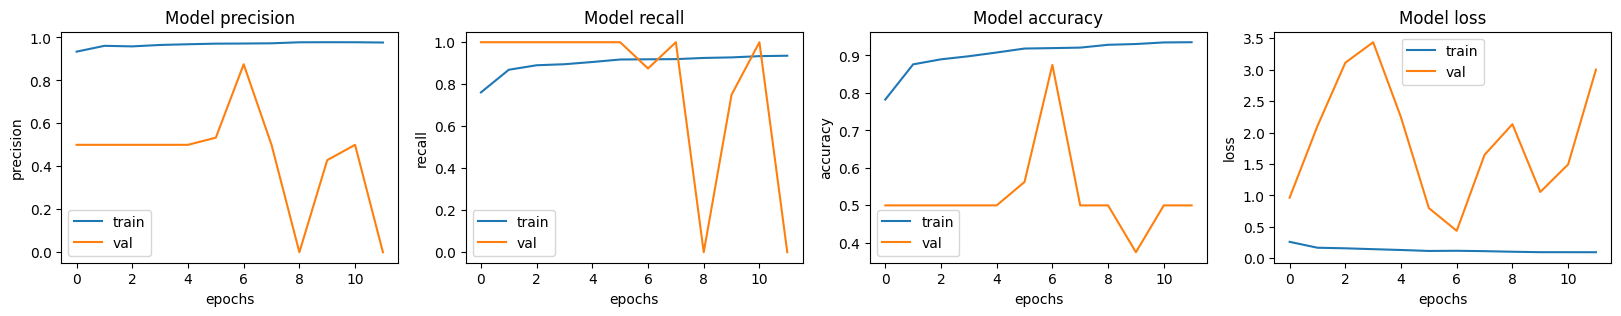

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#Predict and evaluate results


In [37]:
loss, acc, prec, rec = model.evaluate(test_generator)

20/20 [==============================] - 5s 247ms/step - loss: 3.3781 - accuracy: 0.4167 - precision: 0.9333 - recall: 0.0718


#Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

pred=model.predict(test_generator)
print(confusion_matrix(test_generator.classes,pred>0.5))

pd.DataFrame(classification_report(test_generator.classes ,pred >0.5,output_dict=True))

20/20 [==============================] - 9s 408ms/step
[[220  14]
 [374  16]]


,0,1,accuracy,macro avg,weighted avg
precision,0.370370,0.533333,0.378205,0.451852,0.472222
recall,0.940171,0.041026,0.378205,0.490598,0.378205
f1-score,0.531401,0.076190,0.378205,0.303796,0.246894
support,234.000000,390.000000,0.378205,624.000000,624.000000
